In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ===========================
# Global Constants & Labels
# ===========================
DEFAULT_FIG_SIZE = (20, 7)
DEFAULT_DPI = 100

COLOR_STATE = 'blue'
COLOR_LCS_SCORE = 'tab:red'
COLOR_CHANGE_POINT = 'red'

LABEL_STATE = 'state'  # Assumes your CSV has a column named 'state'
TITLE_RAW_DATA = 'Raw State Data Over Time'
TITLE_SEGMENTED_DATA = 'State Data Segmented into Windows'
TITLE_LCS_SCORE = 'LCS Score for Window Size'
TITLE_STATE_PER_WINDOW = 'State per Window'
TITLE_LCS_AND_STATE = 'LCS Score and State per Window'

WINDOW_SIZE = 50
SLIDE_SIZE = 20

user_inputs = {
    'file_path': "",
    'window_size': 50,
    'slide_size': 10,
    'sampling_rate': 1,
    'has_state_column': False,
    'state_column': "",
    'selected_columns': [],
    'normalize': False
}

import tkinter as tk
from tkinter import filedialog, messagebox, ttk
import pandas as pd

GUI_FONT = ("Verdana", 12)

window = tk.Tk()
window.title("CSV Input GUI")
window.geometry("1000x800")

user_inputs = {
    'file_path': "",
    'window_size': 50,
    'slide_size': 10,
    'sampling_rate': 1,
    'has_state_column': False,
    'state_column': "",
    'selected_columns': [],
    'normalize': False
}

state_var = tk.BooleanVar()

def select_file():
    file_path = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
    if file_path:
        user_inputs['file_path'] = file_path
        file_label.config(text=file_path.split("/")[-1])
        try:
            data = pd.read_csv(file_path)
            display_data(data)
            update_dropdown_and_checkboxes(data)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read CSV: {e}")
    else:
        file_label.config(text="No file selected")

def display_data(data):
    preview_text = data.head().to_string(index=False)
    data_preview_text.config(state=tk.NORMAL)
    data_preview_text.delete(1.0, tk.END)
    data_preview_text.insert(tk.END, preview_text)
    data_preview_text.config(state=tk.DISABLED)

def update_dropdown_and_checkboxes(data):
    state_col_dropdown['values'] = data.columns.tolist()
    for widget in checkbox_frame.winfo_children():
        widget.destroy()
    rows, cols = 5, 5
    user_inputs['selected_columns'].clear()
    for i, col in enumerate(data.columns):
        var = tk.BooleanVar()
        checkbox = tk.Checkbutton(checkbox_frame, text=col, variable=var, font=GUI_FONT)
        checkbox.grid(row=i // cols, column=i % cols, sticky="w", padx=10, pady=5)
        user_inputs['selected_columns'].append((col, var))

def on_window_size_change(val):
    val = int(float(val))
    user_inputs['window_size'] = val

def on_sampling_rate_change(val):
    user_inputs['sampling_rate'] = int(val)

def on_submit():
    try:
        user_inputs['normalize'] = normalize_var.get()
        user_inputs['sampling_rate'] = int(sampling_rate_slider.get())
        user_inputs['has_state_column'] = state_var.get()
        user_inputs['state_column'] = state_col_dropdown.get() if user_inputs['has_state_column'] else ""
        
        # Ensure only tuples with exactly two elements are processed
        filtered_columns = []
        for item in user_inputs['selected_columns']:
            if isinstance(item, tuple) and len(item) == 2:
                col, var = item
                if var.get():
                    filtered_columns.append(col)
        
        user_inputs['selected_columns'] = filtered_columns

        print("\nCollected User Inputs:")
        print(f"File Path: {user_inputs['file_path']}")
        print(f"Window Size: {user_inputs['window_size']}")
        print(f"Sampling Rate: {user_inputs['sampling_rate']}")
        print(f"Has State Column: {user_inputs['has_state_column']}")
        print(f"State Column: {user_inputs['state_column']}")
        print("Selected Columns: ", user_inputs['selected_columns'])
        print(f"Normalization: {user_inputs['normalize']}")

        window.destroy()

    except Exception as e:
        messagebox.showerror("Error", f"Invalid input: {e}")

# File Selection Section
tk.Label(window, text="Load CSV:", font=GUI_FONT).pack(pady=(10,0))
tk.Button(window, text="Browse CSV", command=select_file, font=GUI_FONT).pack()
file_label = tk.Label(window, text="No file selected", fg="gray", font=GUI_FONT)
file_label.pack(pady=5)

# Data Preview Section
tk.Label(window, text="Data Preview:", font=GUI_FONT).pack(pady=(10,0))
data_preview_text = tk.Text(window, height=5, width=100, font=GUI_FONT, wrap="none")
data_preview_text.pack(pady=(0,10))
data_preview_text.config(state=tk.DISABLED)

# Center the preview box
data_preview_text.config(width=120)  # Increased the width for better centering

# Checkbox for normalization
normalize_var = tk.BooleanVar()
tk.Checkbutton(window, text="Normalize Data", variable=normalize_var, font=GUI_FONT).pack(pady=10)

# Checkbox Section
checkbox_frame = tk.Frame(window)
checkbox_frame.pack(pady=10)

tk.Checkbutton(window, text="Dataset has state column", variable=state_var, font=GUI_FONT).pack()
tk.Label(window, text="State Column:", font=GUI_FONT).pack(pady=(10,0))
state_col_dropdown = ttk.Combobox(window, font=GUI_FONT)
state_col_dropdown.pack()

# Window Size Section
tk.Label(window, text="Window Size:", font=GUI_FONT).pack(pady=(10,0))
window_size_slider = tk.Scale(window, from_=10, to_=100, resolution=10, orient='horizontal', font=GUI_FONT, 
                              command=on_window_size_change, width=30)  # Increased slider width
window_size_slider.set(50)  # Set default value
window_size_slider.pack()

# Sampling Rate Section (Discrete Slider)
tk.Label(window, text="Sampling Rate:", font=GUI_FONT).pack(pady=(10,0))
sampling_rate_slider = tk.Scale(window, from_=1, to_=10, resolution=1, orient='horizontal', font=GUI_FONT, showvalue=True, command=on_sampling_rate_change, width=30,length=100)  # Increased slider width
sampling_rate_slider.set(1)  # Set default value
sampling_rate_slider.pack()

# Sliding Factor Section (Simple Input Box)
tk.Label(window, text="Sliding Factor:", font=GUI_FONT).pack(pady=(10,0))
sliding_factor_entry = tk.Entry(window, font=GUI_FONT)
sliding_factor_entry.pack()

# Submit Button
tk.Button(window, text="Submit & Close", command=on_submit, font=GUI_FONT).pack(pady=15)

window.mainloop()



Collected User Inputs:
File Path: C:/Users/adnan/work_2025/DRUM/data1.csv
Window Size: 100
Sampling Rate: 10
Has State Column: True
State Column: state
Selected Columns:  ['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9']
Normalization: True


In [74]:
# Function to load data
def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        print("Data loaded successfully!")
        return data
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

# Function to segment data into windows
def segment_data(data, window_size, slide_size):
    windows = []
    start_idx = 0
    while start_idx + window_size <= len(data):
        windows.append(data.iloc[start_idx:start_idx + window_size])
        start_idx += slide_size
    return windows

import pandas as pd
import numpy as np

# Function to normalize data accumulatively
def normalize_data_accumulative(data, columns):
    for col in columns:
        cumulative_mean = data[col].expanding().mean()
        cumulative_std = data[col].expanding().std()

        # Avoid division by zero in case std is zero
        data[col] = (data[col] - cumulative_mean) / cumulative_std.replace(0, np.nan)
    return data

# Function to find the majority state in each window
def find_majority_states(windows, state_column):
    majority_states = []
    for window in windows:
        if state_column in window.columns:
            # Determine the most frequent state in the current window
            majority_state = window[state_column].mode()[0]
            majority_states.append(majority_state)
        else:
            majority_states.append(None)
    return majority_states

# Function to find change points in the majority states
def find_state_change_points(majority_states):
    change_points = []
    for i in range(1, len(majority_states)):
        if majority_states[i] != majority_states[i-1]:
            change_points.append(i)  # Index where the change occurs
    return change_points
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_states_per_window(assigned_labels, scatter_marker_size=50):
    # Define 16 IEEE-compliant colors
    ieee_colors = ListedColormap([
        "#0071C5", "#F4B300", "#F44242", "#00A44B", "#6A1FBF",
        "#FF6F00", "#39B4E7", "#D95319", "#EDB120", "#77AC30",
        "#4DBEEE", "#A2142F", "#5E5E5E", "#AA00FF", "#FFB300", "#00FFFF"
    ])

    # Convert labels to string and filter None
    labels_as_str = [str(label) for label in assigned_labels if label is not None]

    # Get unique states and their respective colors
    unique_states = sorted(set(labels_as_str))
    state_to_color = {state: ieee_colors.colors[i % len(ieee_colors.colors)] for i, state in enumerate(unique_states)}

    # Indices for plotting
    indices = list(range(len(labels_as_str)))

    # Calculate the appropriate number of ticks (around 20 ticks)
    max_index = len(indices) - 1
    tick_interval = max(100, ((max_index // 20) // 100) * 100)# Avoid division by zero and ensure at least one tick

    # Plotting
    plt.figure(figsize=(16, 7), dpi=300)
    scatter = plt.scatter(
        indices,
        labels_as_str,
        c=[state_to_color[label] for label in labels_as_str],
        alpha=0.8,
        s=scatter_marker_size,
        cmap=ieee_colors
    )
    plt.xlabel("Window Index")
    plt.ylabel("State")
    plt.title("States per Window")
    plt.xticks(ticks=np.arange(0, max_index + 1, tick_interval), rotation=45)  # Adjust tick placement
 # Rotate ticks for better visibility
    plt.yticks(ticks=range(len(unique_states)), labels=unique_states)
    #plt.colorbar(scatter, label='State Color')  # Adding a label to the color bar for clarity
    plt.show()


def compute_majority_labels(windows, state_column):
    majority_labels = []
    for window in windows:
        if state_column in window.columns:
            # Compute the mode (most common element) of the state column in the current window
            majority_label = window[state_column].mode()[0] if not window[state_column].empty else None
            majority_labels.append(majority_label)
        else:
            # If the state column is missing in the window, append None or an appropriate placeholder
            majority_labels.append(None)
    return majority_labels

# Global parameters for LCS calculation
alpha = 1/3  # Impact of mean difference
beta = 1/3   # Impact of standard deviation difference
gamma = 1/3  # Impact of frame intersections

LCS_THRESHOLD = 0.6  # Threshold for marking change points in LCS plot

LABEL_STATE = 'state'  # Set this based on your state column

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Function to count intersections between data and its running mean
def count_intersections(data, running_mean):
    intersections = 0
    for i in range(1, len(data)):
        if (data[i-1] > running_mean[i-1] and data[i] <= running_mean[i]) or \
           (data[i-1] < running_mean[i-1] and data[i] >= running_mean[i]):
            intersections += 1
    return intersections

# Function to calculate LCS for windows
def calculate_lcs(windows):
    lcs_scores = []
    majority_states = []

    for i in tqdm(range(len(windows)), desc='Calculating LCS for windows'):
        window = windows[i]
        majority_state = window[LABEL_STATE].mode()[0] if LABEL_STATE in window.columns else None
        majority_states.append(majority_state)

        if i > 0:
            prev_window = windows[i-1]
            delta_m = np.abs(window['value'].mean() - prev_window['value'].mean())
            delta_s = np.abs(window['value'].std() - prev_window['value'].std())

            running_mean = window['value'].rolling(window=len(window), min_periods=1).mean()
            prev_running_mean = prev_window['value'].rolling(window=len(prev_window), min_periods=1).mean()
            intersections_current = count_intersections(window['value'].values, running_mean.values)
            intersections_previous = count_intersections(prev_window['value'].values, prev_running_mean.values)
            delta_frm = np.abs(intersections_current - intersections_previous)

            lcs = alpha * delta_m + beta * delta_s + gamma * delta_frm
            lcs_scores.append(lcs)
        else:
            lcs_scores.append(0)  # First window has no previous to compare with

    # Normalize LCS scores
    if len(lcs_scores) > 1:
        min_lcs = min(lcs_scores[1:])  # skip the first
        max_lcs = max(lcs_scores[1:])
        normalized_lcs = [0] + [(x - min_lcs) / (max_lcs - min_lcs) if max_lcs != min_lcs else 0 for x in lcs_scores[1:]]
    else:
        normalized_lcs = lcs_scores

    return pd.DataFrame({
        'Window Index': range(len(windows)),
        'LCS Score': normalized_lcs,
        'Majority State': majority_states
    })

# Function to plot LCS with optional threshold-based change points
def plot_lcs_scores_with_threshold(lcs_df):
    plt.figure(figsize=(16, 6))
    plt.plot(lcs_df['Window Index'], lcs_df['LCS Score'], color='tab:red', label='LCS Score')

    if LCS_THRESHOLD is not None:
        high_lcs_points = lcs_df[lcs_df['LCS Score'] > LCS_THRESHOLD]['Window Index']
        for cp in high_lcs_points:
            plt.axvline(x=cp, color='gray', linestyle='--', linewidth=1, alpha=1)
        plt.axhline(y=LCS_THRESHOLD, color='black', linestyle='--', label=f'Threshold = {LCS_THRESHOLD}')

    plt.xlabel("Window Index")
    plt.ylabel("Normalized LCS Score")
    plt.title("LCS Score per Window" + (f" (Threshold = {LCS_THRESHOLD})"))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [65]:
# Manually override user inputs (bypass GUI)

user_inputs = {
    'file_path': 'ETTh1.csv',  # Path to your CSV file
    'window_size': 50,
    'slide_size': 30,
    'sampling_rate': 1,
    'has_state_column': False,
    'state_column': 'state',
    'selected_columns': ['HULL','MULL'],  # Columns to process
    'normalize': True
}

# Optional: Print confirmation
print("Manual user input values set:")
for key, value in user_inputs.items():
    print(f"{key}: {value}")


Manual user input values set:
file_path: ETTh1.csv
window_size: 50
slide_size: 30
sampling_rate: 1
has_state_column: False
state_column: state
selected_columns: ['HULL', 'MULL']
normalize: True


In [79]:
def calculate_lcs(windows, selected_columns):
    lcs_scores = []
    majority_states = []

    for i in tqdm(range(len(windows)), desc='Calculating LCS for windows'):
        window = windows[i]
        majority_state = window[LABEL_STATE].mode()[0] if LABEL_STATE in window.columns else None
        majority_states.append(majority_state)

        if i > 0:
            prev_window = windows[i - 1]

            delta_m, delta_s, delta_frm = 0, 0, 0

            for col in selected_columns:
                delta_m += np.abs(window[col].mean() - prev_window[col].mean())
                delta_s += np.abs(window[col].std() - prev_window[col].std())

                running_mean = window[col].rolling(window=len(window), min_periods=1).mean()
                prev_running_mean = prev_window[col].rolling(window=len(prev_window), min_periods=1).mean()

                intersections_current = count_intersections(window[col].values, running_mean.values)
                intersections_previous = count_intersections(prev_window[col].values, prev_running_mean.values)
                delta_frm += np.abs(intersections_current - intersections_previous)

            lcs = alpha * delta_m + beta * delta_s + gamma * delta_frm
            lcs_scores.append(lcs)
        else:
            lcs_scores.append(0)

    # Normalize LCS
    if len(lcs_scores) > 1:
        min_lcs = min(lcs_scores[1:])
        max_lcs = max(lcs_scores[1:])
        normalized_lcs = [0] + [(x - min_lcs) / (max_lcs - min_lcs) if max_lcs != min_lcs else 0 for x in lcs_scores[1:]]
    else:
        normalized_lcs = lcs_scores

    return pd.DataFrame({
        'Window Index': range(len(windows)),
        'LCS Score': normalized_lcs,
        'Majority State': majority_states
    })

import matplotlib.pyplot as plt

def plot_lcs_scores_with_changes(lcs_df, change_points=None):
    """
    Plots normalized LCS scores per window. Adds dashed lines for change points if provided.

    Parameters:
    - lcs_df: DataFrame with 'Window Index' and 'LCS Score' columns
    - change_points: list of window indices where state changes occur (optional)
    """
    plt.figure(figsize=(16, 6))
    plt.plot(lcs_df['Window Index'], lcs_df['LCS Score'], color='tab:red', label='LCS Score')

    # Add dashed vertical lines for change points, if available
    if change_points:
        for cp in change_points:
            plt.axvline(x=cp, color='gray', linestyle='--', linewidth=1, alpha=0.6)

    plt.xlabel("Window Index")
    plt.ylabel("Normalized LCS Score")
    plt.title("LCS Score per Window" + (" with State Change Points" if change_points else ""))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
def plot_selected_variables(file_path, selected_columns, colors):
    """
    Plots selected variables from a CSV file using the provided colors.

    Parameters:
    file_path (str): Path to the CSV file.
    selected_columns (list): List of column names to plot.
    colors (list): List of colors for each variable.
    """
    plt.style.use('classic')
    data = pd.read_csv(file_path)

    num_vars = len(selected_columns)
    if len(colors) < num_vars:
        raise ValueError("Not enough colors provided for the number of selected variables.")

    fig, axs = plt.subplots(num_vars, 1, figsize=(20, 2 * num_vars))

    for i, col in enumerate(selected_columns):
        ax = axs[i] if num_vars > 1 else axs
        if col not in data.columns:
            raise ValueError(f"{col} not found in the dataset.")
        ax.plot(data[col], color=colors[i], label=col)
        ax.set_title(f'{col}', fontsize=14)
        ax.set_ylabel('Value', fontsize=12)
        ax.set_xlabel('Index', fontsize=12)
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


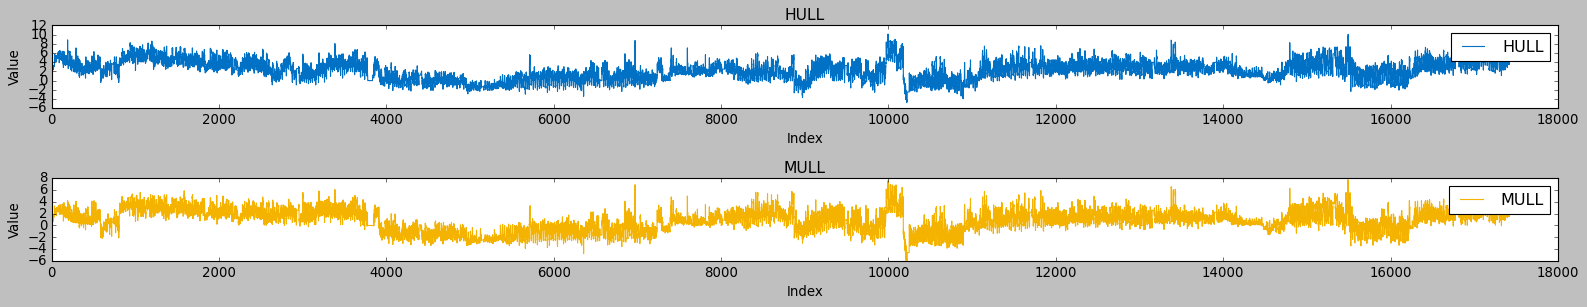

In [80]:
ieee_colors = [
    "#0071C5", "#F4B300", "#F44242", "#00A44B", "#6A1FBF",
    "#FF6F00", "#39B4E7", "#D95319", "#EDB120", "#77AC30"
]

plot_selected_variables(
    user_inputs['file_path'],
    user_inputs['selected_columns'],
    ieee_colors
)


In [81]:
if __name__ == "__main__":
    # Load data from the file path specified by the user
    data = load_data(user_inputs['file_path'])

    if data is not None:
        # Normalize selected columns if normalization is enabled
        if user_inputs['normalize']:
            data = normalize_data_accumulative(data, user_inputs['selected_columns'])
        
        # Segment the data based on user inputs
        windows = segment_data(data, user_inputs['window_size'], user_inputs['slide_size'])
        print("Data segmentation complete. Number of windows:", len(windows))

        if user_inputs['has_state_column'] and user_inputs['state_column'] in data.columns:
            # Calculate the majority states for each window if the state column exists
            assigned_labels = compute_majority_labels(windows, user_inputs['state_column'])
            
            # Plot states per window using the computed majority labels
            plot_states_per_window(assigned_labels, scatter_marker_size=100)  # Adjust size as needed
        else:
            print("State column not specified or not found in the dataset. Skipping state-related analysis.")


Data loaded successfully!
Data segmentation complete. Number of windows: 580
State column not specified or not found in the dataset. Skipping state-related analysis.


Calculating LCS for windows: 100%|██████████████████████████████████████████████████| 580/580 [00:01<00:00, 545.55it/s]


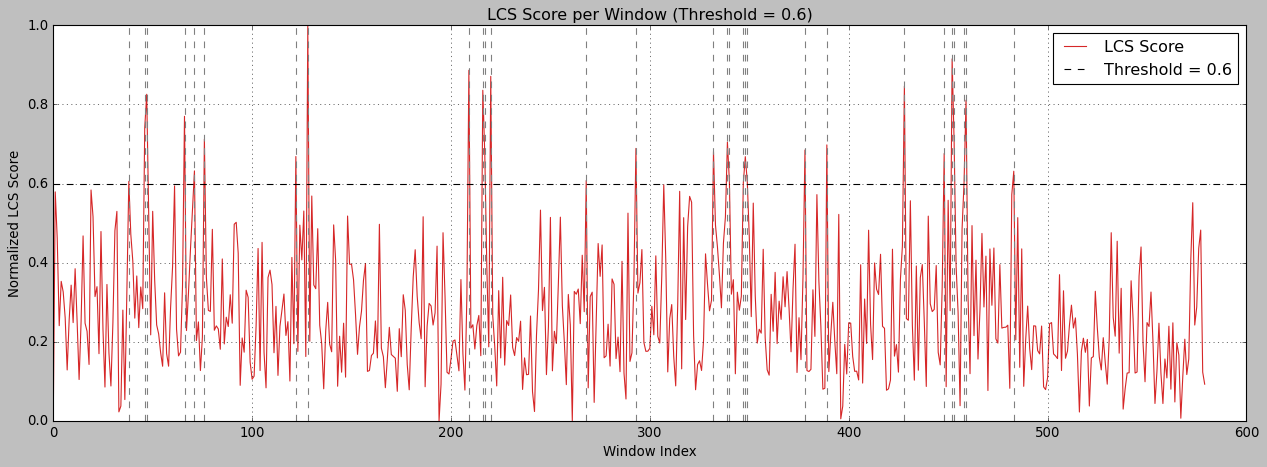

In [83]:
lcs_results = calculate_lcs(windows, user_inputs['selected_columns'])
plot_lcs_scores_with_threshold(lcs_results)


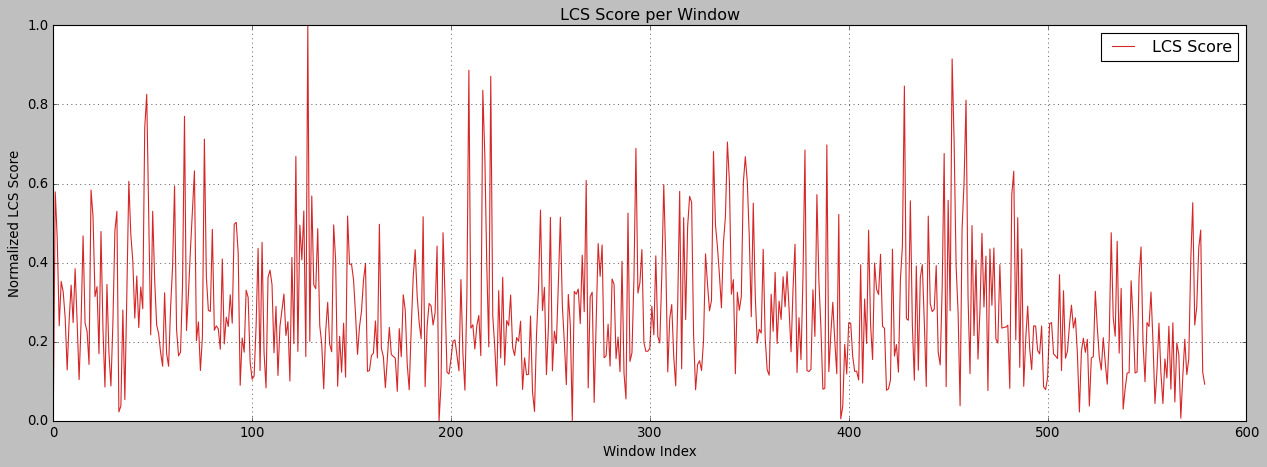

In [84]:
# After calculating lcs_results
if user_inputs['has_state_column'] and user_inputs['state_column'] in data.columns:
    majority_states = lcs_results['Majority State'].tolist()
    change_points = find_state_change_points(majority_states)
else:
    change_points = None

plot_lcs_scores_with_changes(lcs_results, change_points)


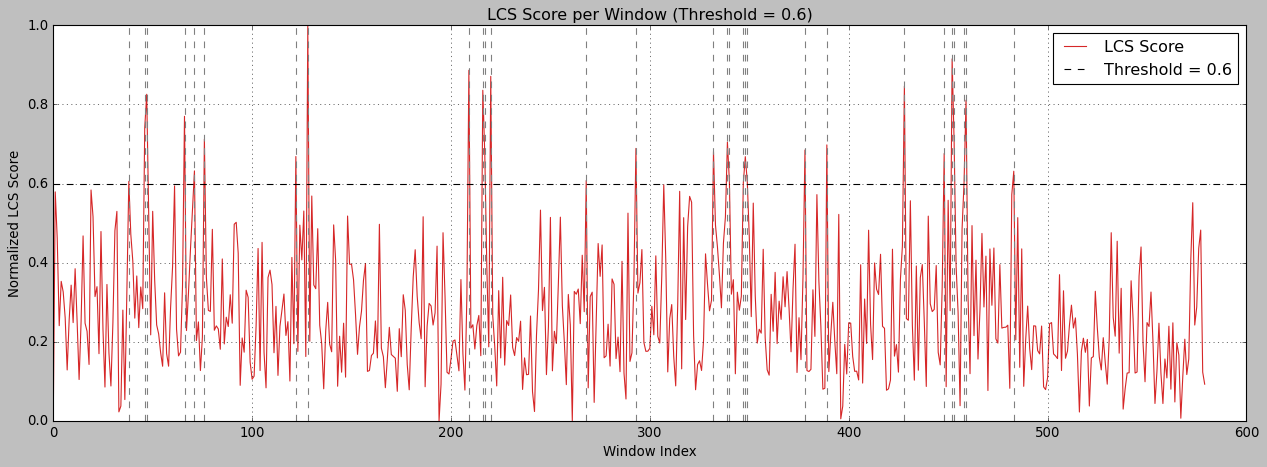

In [86]:
plot_lcs_scores_with_threshold(lcs_results)

In [89]:
def plot_data_with_lcs_change_points(data, lcs_df, selected_columns, threshold):
    """
    Plots normalized original data with vertical dashed lines at LCS-based change points.

    Parameters:
    - data (pd.DataFrame): Original dataset
    - lcs_df (pd.DataFrame): Output from calculate_lcs()
    - selected_columns (list): Columns to plot
    - threshold (float): LCS threshold to mark change points
    """
    # Normalize selected columns
    normalized_data = data.copy()
    for col in selected_columns:
        min_val = normalized_data[col].min()
        max_val = normalized_data[col].max()
        normalized_data[col] = (normalized_data[col] - min_val) / (max_val - min_val)

    # Get LCS change point window indices
    high_lcs_windows = lcs_df[lcs_df['LCS Score'] > threshold]['Window Index']

    # Map window indices to approximate center index in original data
    change_indices = [
        i * user_inputs['slide_size'] + user_inputs['window_size'] // 2
        for i in high_lcs_windows
    ]

    # Plot
    plt.figure(figsize=(16, 6))
    for col in selected_columns:
        plt.plot(normalized_data[col].values, label=col)

    for idx in change_indices:
        plt.axvline(x=idx, color='gray', linestyle='--', alpha=1)

    plt.xlabel("Time Index")
    plt.ylabel("Normalized Value")
    plt.title("Normalized Data with LCS-based Change Points")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


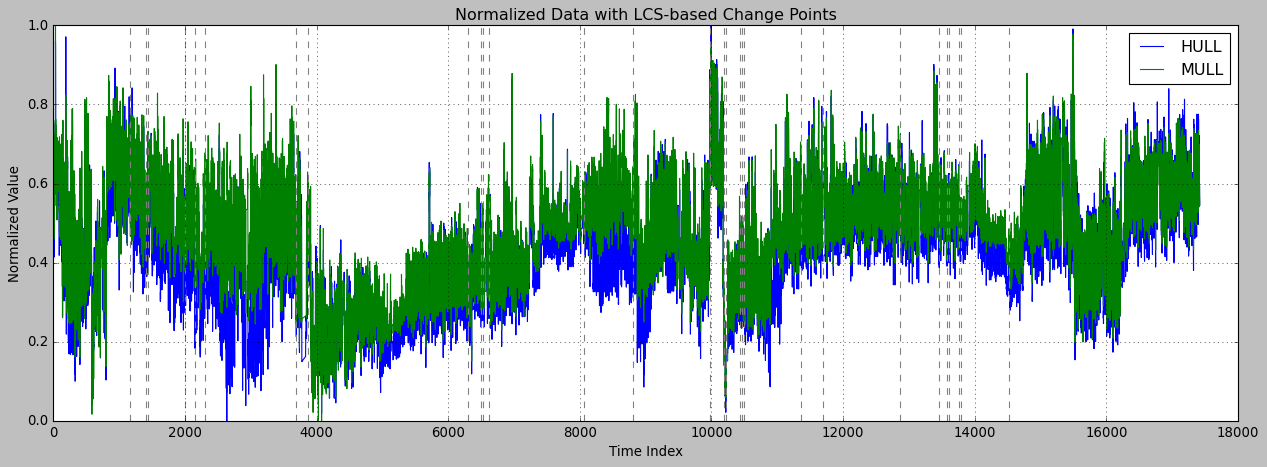

In [90]:
plot_data_with_lcs_change_points(
    data=data,
    lcs_df=lcs_results,
    selected_columns=user_inputs['selected_columns'],
    threshold=LCS_THRESHOLD
)
